In [2]:
import torch
import clip
from PIL import Image

/home/zentner/language-to-policies/venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zentner/language-to-policies/venv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
import sys
sys.path.append('/home/zentner/language-to-policies/src/')
print(sys.path)

['/home/zentner/language-to-policies/notebooks', '/usr/local/buildtools/current/sitecustomize', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/zentner/language-to-policies/venv/lib/python3.9/site-packages', '/home/zentner/language-to-policies/metaworld', '/home/zentner/language-to-policies/src/']


In [5]:
import metaworld_voxel_env

/home/zentner/language-to-policies/venv/lib/python3.9/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from metaworld_controllers import DECISION_TREES, CONTROLLERS, SawyerUniversalV2Policy

In [7]:
env_name = 'drawer-open'
env = metaworld_voxel_env.MetaWorldVoxelEnv(env_name=env_name, seed=100, camera_names=['corner4'], img_width=224, img_height=224)

/home/zentner/language-to-policies/venv/lib/python3.9/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
policy = SawyerUniversalV2Policy(env_name=env_name)

In [ ]:
obs = env.reset()
observations = []
controller_names = []
for i in range(100):
    tree = DECISION_TREES[env_name]['function']
    o_d = policy._parse_obs(obs['low_dim'])
    controller_name = tree(o_d)
    controller_names.append(controller_name)
    observations.append(obs)
    action = policy.get_action(obs['low_dim'])
    obs, reward, done, info = env.step(action)

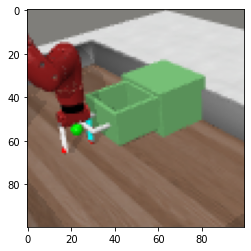

In [63]:
import matplotlib.pyplot as plt
plt.imshow(obs['imgs']['color_imgs']['corner4'])
plt.show()

In [66]:
def obs_to_clip(obs):
    image = preprocess(Image.fromarray(obs['imgs']['color_imgs']['corner4'])).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        return image_features

from collections import defaultdict
obs_for_con_name = defaultdict(list)
for (con_name, obs) in zip(controller_names, observations):
    obs_for_con_name[con_name].append(obs)

features_for_con_name = {}
for (con_name, obses) in obs_for_con_name.items():
    features_for_con_name[con_name] = torch.mean(torch.cat([obs_to_clip(obs) for obs in obses]), axis=0)

In [77]:
for con_name in features_for_con_name.keys():
    features_for_con_name[con_name] /= features_for_con_name[con_name].norm()

In [84]:
import numpy as np
np.random.choice?

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the ``choice`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a uniform distribution over all
    entr

In [91]:
def choose_controller(obs, use_max=False):
    image_features = obs_to_clip(obs).squeeze()
    image_features /= image_features.norm()
    if use_max:
        print([(con_name, torch.dot(image_features, features))
               for (con_name, features) in features_for_con_name.items()])
        return max(list(features_for_con_name.items()), key=lambda p: torch.dot(image_features, p[1]))[0]
    else:
        con_logits = np.asarray([torch.dot(image_features, features)
                                 for (con_name, features) in features_for_con_name.items()])
        con_logits /= con_logits.sum()
        return np.random.choice(list(features_for_con_name.keys()), p=con_logits)

choose_controller(obs)

'pull away from drawer'

[('put gripper above drawer handle', tensor(0.9863)), ('put gripper around drawer handle', tensor(0.9736)), ('pull away from drawer', tensor(0.9622))]
[('put gripper above drawer handle', tensor(0.9904)), ('put gripper around drawer handle', tensor(0.9822)), ('pull away from drawer', tensor(0.9717))]
[('put gripper above drawer handle', tensor(0.9914)), ('put gripper around drawer handle', tensor(0.9833)), ('pull away from drawer', tensor(0.9720))]
[('put gripper above drawer handle', tensor(0.9930)), ('put gripper around drawer handle', tensor(0.9794)), ('pull away from drawer', tensor(0.9664))]
[('put gripper above drawer handle', tensor(0.9933)), ('put gripper around drawer handle', tensor(0.9816)), ('pull away from drawer', tensor(0.9664))]
[('put gripper above drawer handle', tensor(0.9936)), ('put gripper around drawer handle', tensor(0.9836)), ('pull away from drawer', tensor(0.9692))]
[('put gripper above drawer handle', tensor(0.9930)), ('put gripper around drawer handle', ten

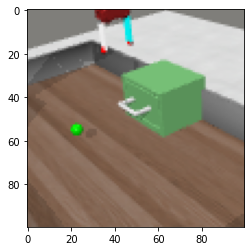

In [98]:
obs = env.reset()
for i in range(100):
    controller_name = choose_controller(obs, use_max=True)
    action = policy.run_controller(controller_name, obs['low_dim'])
    obs, reward, done, info = env.step(action)
plt.imshow(obs['imgs']['color_imgs']['corner4'])
plt.show()

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 1